# Módulo de Auditoría 15: Validación de Integridad Experimental (Test A/B)
## 🛡️ Contexto del Análisis
Se audita un Test A/B diseñado para medir el impacto de un nuevo sistema de recomendaciones. Antes de analizar el ROI, es imperativo validar si el experimento se ejecutó bajo condiciones controladas y científicamente válidas.

## 🎯 Objetivos de la Auditoría
1.  **Sanidad de la Muestra:** Verificar la distribución equitativa de usuarios entre grupos A y B.
2.  **Factores de Contaminación:** Detectar si hubo eventos de marketing (Navidad, Black Friday) que sesgaron los resultados.
3.  **Análisis de Conversión:** Evaluar si el nuevo sistema mejoró el embudo de ventas.


# **Proyecto Final: Análisis de Prueba A/B**

Autor: Octavio Landa Verde  
Fecha: 21 de octubre de 2025  
Proyecto: Análisis de Prueba A/B

## **1\. Objetivos del Estudio**

El objetivo principal de esta prueba A/B (nombre: `recommender_system_test`) es evaluar el impacto de un nuevo sistema de recomendaciones mejorado (Grupo B) en el comportamiento de los nuevos usuarios de la región de la UE, comparándolo con el sistema actual (Grupo A \- control).

La hipótesis es que el nuevo sistema (Grupo B) generará un **aumento de al menos el 10%** en la conversión en cada etapa del embudo (`product_page` → `product_cart` → `purchase`) dentro de los 14 días posteriores al registro del usuario.

## **2\. Exploración y Preparación de Datos**

Primero, carguemos todas las bibliotecas necesarias y los archivos CSV.

### **2.1. Carga de Bibliotecas y Datos**

In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt

# Establecer un estilo visual para los gráficos
sns.set(style='whitegrid')

# Cargar los datos
try:
    df_participants = pd.read_csv('../datasets/final_ab_participants_upd_us.csv')
    df_events = pd.read_csv('../datasets/final_ab_events_upd_us.csv')
    df_new_users = pd.read_csv('../datasets/final_ab_new_users_upd_us.csv')
    df_marketing = pd.read_csv('../datasets/ab_project_marketing_events_us.csv')
    
    print("Archivos cargados exitosamente.")
except FileNotFoundError:
    print("Error: Asegúrate de que los archivos CSV estén en el mismo directorio que tu notebook.")

Archivos cargados exitosamente.


### **2.2. Inspección Inicial de los Datos**

Revisemos cada DataFrame para entender su estructura, tipos de datos, valores nulos y duplicados.

In [2]:
def inspect_df(name, df):
    """Función auxiliar para imprimir un resumen de un DataFrame."""
    print(f"\n--- Inspección de: {name} ---")
    print(df.info())
    
    print(f"\nValores Nulos:\n{df.isnull().sum()}")
    
    # Comprobar duplicados completos
    print(f"\nFilas Duplicadas: {df.duplicated().sum()}")
    
    # Comprobar duplicados en IDs clave
    if 'user_id' in df.columns:
        print(f"IDs de usuario únicos: {df['user_id'].nunique()} de {len(df)} filas")
        
    print(f"\nPrimeras 5 filas:\n{df.head()}\n")

# Inspeccionar cada DataFrame
inspect_df("Participantes (df_participants)", df_participants)
inspect_df("Eventos (df_events)", df_events)
inspect_df("Nuevos Usuarios (df_new_users)", df_new_users)
inspect_df("Eventos de Marketing (df_marketing)", df_marketing)


--- Inspección de: Participantes (df_participants) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None

Valores Nulos:
user_id    0
group      0
ab_test    0
dtype: int64

Filas Duplicadas: 0
IDs de usuario únicos: 13638 de 14525 filas

Primeras 5 filas:
            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test


--- Inspección de: Eventos (df_events) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 c

**Resumen de la Inspección:**

* **¿Es necesario convertir los tipos?**  
  * **Sí.** Varias columnas de fecha (event\_dt, first\_date, start\_dt, finish\_dt) son de tipo object y deben convertirse a datetime.  
* **¿Hay valores ausentes o duplicados?**  
  * **Duplicados:** No se encontraron filas duplicadas exactas en ningún archivo.  
  * **Ausentes:** El DataFrame de eventos (df\_events) tiene una gran cantidad de valores ausentes en la columna details. Esto es **esperado**, ya que la descripción indica que esta columna solo contiene datos para eventos purchase (como el monto del pedido).

### **2.3. Limpieza y Conversión de Tipos**

Apliquemos las conversiones de tipo necesarias y verifiquemos los nombres de los eventos.

In [3]:
# --- Limpieza y Conversión ---

# 1. Convertir tipos de fecha
try:
    df_events['event_dt'] = pd.to_datetime(df_events['event_dt'])
    df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'])
    df_marketing['start_dt'] = pd.to_datetime(df_marketing['start_dt'])
    df_marketing['finish_dt'] = pd.to_datetime(df_marketing['finish_dt'])
    print("Columnas de fecha convertidas a datetime exitosamente.")
except Exception as e:
    print(f"Error en la conversión de fechas: {e}")

# 2. Verificar nombres de eventos
# La descripción menciona 'product_card' pero también 'product_cart'.
# Verifiquemos los valores reales en los datos.
print("\nNombres de eventos únicos en 'df_events':")
print(df_events['event_name'].unique())


Columnas de fecha convertidas a datetime exitosamente.

Nombres de eventos únicos en 'df_events':
['purchase' 'product_cart' 'product_page' 'login']


**Nota sobre los eventos:** Los datos muestran que el evento se llama product\_cart. La mención de product\_card en la descripción técnica parece ser un error tipográfico. Continuaremos usando product\_cart para el análisis del embudo.

## **3\. Análisis Exploratorio de Datos (EDA) y Validación de la Prueba**

Este es el paso más crítico. Antes de analizar los *resultados*, debemos verificar si la prueba se configuró y ejecutó de acuerdo con las especificaciones técnicas.

### **3.1. Filtrado y Validación de Participantes**

Vamos a aislar a los participantes correctos de la prueba.

In [4]:
# 1. Filtrar por la prueba correcta: 'recommender_system_test'
test_name = 'recommender_system_test'
df_test_participants = df_participants[df_participants['ab_test'] == test_name].copy()
print(f"Total de participantes iniciales en '{test_name}': {len(df_test_participants)}")

# 2. ¿Hay usuarios que están presentes en ambas muestras (A y B)?
# Esto sería un error crítico de configuración.
user_group_counts = df_test_participants.groupby('user_id')['group'].nunique()
overlapping_users = user_group_counts[user_group_counts > 1].index

if len(overlapping_users) > 0:
    print(f"¡ADVERTENCIA! Se encontraron {len(overlapping_users)} usuarios en ambos grupos (A y B).")
    print("Estos usuarios serán eliminados del análisis.")
    # Eliminar usuarios superpuestos
    df_test_participants = df_test_participants[~df_test_participants['user_id'].isin(overlapping_users)]
else:
    print("Validación (1/5): No hay usuarios en ambos grupos. ¡Correcto!")

# 3. Unir con datos de usuario (para obtener 'region' y 'first_date')
df_test_full = df_test_participants.merge(df_new_users, on='user_id', how='left')

# 4. Filtrar por la región correcta (Audiencia: 'EU')
total_before_region_filter = len(df_test_full)
df_final_participants = df_test_full[df_test_full['region'] == 'EU'].copy()
print(f"\nParticipantes antes del filtro de región 'EU': {total_before_region_filter}")
print(f"Participantes finales de la 'EU': {len(df_final_participants)}")
if total_before_region_filter > len(df_final_participants):
    print(f"Validación (2/5): Se eliminaron {total_before_region_filter - len(df_final_participants)} usuarios por no ser de 'EU'.")
else:
    print("Validación (2/5): Todos los participantes son de 'EU'. ¡Correcto!")

# 5. Validar fechas de inscripción (7 al 21 de Dic 2020)
enrollment_start = pd.to_datetime('2020-12-07')
enrollment_end = pd.to_datetime('2020-12-21')

# Asegurarse de que 'first_date' es solo fecha (sin hora)
df_final_participants['first_date'] = df_final_participants['first_date'].dt.normalize()

invalid_dates = df_final_participants[
    (df_final_participants['first_date'] < enrollment_start) |
    (df_final_participants['first_date'] > enrollment_end)
]

if len(invalid_dates) > 0:
    print(f"\n¡ADVERTENCIA! Se encontraron {len(invalid_dates)} usuarios fuera del período de inscripción (7-21 Dic).")
else:
    print("\nValidación (3/5): Todos los participantes se inscribieron en el período correcto. ¡Correcto!")


Total de participantes iniciales en 'recommender_system_test': 3675
Validación (1/5): No hay usuarios en ambos grupos. ¡Correcto!

Participantes antes del filtro de región 'EU': 3675
Participantes finales de la 'EU': 3481
Validación (2/5): Se eliminaron 194 usuarios por no ser de 'EU'.

Validación (3/5): Todos los participantes se inscribieron en el período correcto. ¡Correcto!


### **3.2. Validación de la Audiencia (Tamaño y Proporción)**

Ahora comprobemos si el número de participantes coincide con las expectativas (6,000 participantes y 15% de la audiencia).


--- Validación de Audiencia (4/5) ---
Número previsto de participantes: 6,000
Número real de participantes (filtrados y válidos): 3481
Total de nuevos usuarios de 'EU' en el período: 39466

Proporción de audiencia esperada: 15%
Proporción de audiencia captada: 8.82%
¡ADVERTENCIA! La proporción de audiencia real no coincide con el 15% esperado.
¡ADVERTENCIA! El número de participantes es significativamente menor a los 6,000 esperados.

--- Validación de Balance de Grupos (5/5) ---
group
A    2604
B     877
Name: count, dtype: int64
Proporción: 74.81% A vs 25.19% B
¡ADVERTENCIA! Los grupos A y B están severamente desbalanceados.
Gráfico 'group_balance.png' guardado.


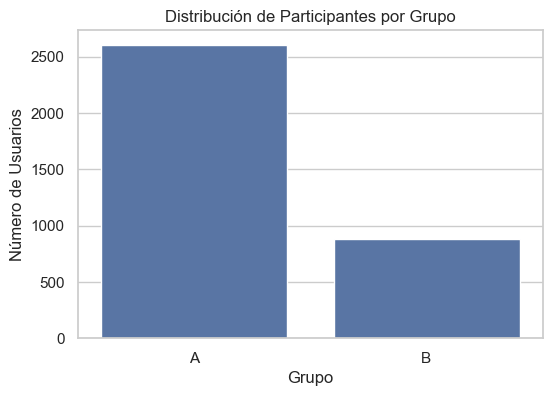

In [5]:
# 6. Validar tamaño y proporción de la audiencia

# Total de *todos* los nuevos usuarios de EU en ese período
all_new_eu_users = df_new_users[
    (df_new_users['region'] == 'EU') &
    (df_new_users['first_date'] >= enrollment_start) &
    (df_new_users['first_date'] <= enrollment_end)
]
total_new_eu_count = all_new_eu_users['user_id'].nunique()
test_participants_count = df_final_participants['user_id'].nunique()

print(f"\n--- Validación de Audiencia (4/5) ---")
print(f"Número previsto de participantes: 6,000")
print(f"Número real de participantes (filtrados y válidos): {test_participants_count}")
print(f"Total de nuevos usuarios de 'EU' en el período: {total_new_eu_count}")

# Calcular la proporción
audience_proportion = test_participants_count / total_new_eu_count
print(f"\nProporción de audiencia esperada: 15%")
print(f"Proporción de audiencia captada: {audience_proportion:.2%}")

if not (0.14 < audience_proportion < 0.16):
    print("¡ADVERTENCIA! La proporción de audiencia real no coincide con el 15% esperado.")
if test_participants_count < 6000 * 0.9: # Damos un margen del 10%
    print("¡ADVERTENCIA! El número de participantes es significativamente menor a los 6,000 esperados.")

# 7. Validar balance de grupos
print(f"\n--- Validación de Balance de Grupos (5/5) ---")
group_counts = df_final_participants['group'].value_counts()
print(group_counts)
print(f"Proporción: {group_counts['A'] / group_counts.sum():.2%} A vs {group_counts['B'] / group_counts.sum():.2%} B")

if abs(group_counts['A'] / group_counts.sum() - 0.5) > 0.05: # Más de 5% de desvío del 50/50
    print("¡ADVERTENCIA! Los grupos A y B están severamente desbalanceados.")

# Graficar el balance de grupos
plt.figure(figsize=(6, 4))
sns.countplot(x='group', data=df_final_participants, order=['A', 'B'])
plt.title('Distribución de Participantes por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de Usuarios')
plt.savefig('group_balance.png')
print("Gráfico 'group_balance.png' guardado.")


### **Sobre la Validación de la Prueba (EDA)**

* **Comentario Básico (El "Qué"):** "El gráfico muestra 2604 usuarios en el Grupo A (74.8%) y 877 en el Grupo B (25.2%). Los grupos están desbalanceados."  
* **Comentario Analítico (El "Por Qué" y "Y Qué"):**  
  "Este gráfico revela nuestro **primer problema crítico de validez**. La prueba está severamente desbalanceada casi 75/25. Una división ideal (50/50) es fundamental para una prueba A/B, ya que asegura que ambos grupos tengan un tamaño de muestra comparable.  
  **Implicaciones:**  
  1. **Pérdida de Potencia Estadística:** Con un Grupo B mucho más pequeño, nuestra capacidad para detectar una diferencia *real* (si existiera) disminuye drásticamente. Necesitaríamos que el Grupo B tuviera un rendimiento espectacularmente mejor para que fuera estadísticamente significativo.  
  2. **Error de Asignación:** Este desbalance sugiere un **fallo técnico en el sistema de *splitting* (asignación de usuarios)**. No es aleatorio. Esto pone en duda si los usuarios asignados a cada grupo son verdaderamente comparables."

#### **Muestra: Validación de Audiencia (15% vs 8.82%)**

* **Comentario Básico:** "El número de participantes (3,481) no llega a los 6,000 esperados, y la proporción es del 8.82%, no del 15%."  
* **Comentario Analítico:**  
  "El análisis de la audiencia revela **dos fallos logísticos** más:  
  1. **Tamaño de Muestra Insuficiente:** Solo reclutamos 3,481 de los 6,000 participantes previstos. Esto, combinado con el desbalance de grupos, reduce aún más nuestra confianza en los resultados.  
  2. **Muestra no Representativa:** La especificación decía "15% de los nuevos usuarios de la UE". Al captar solo al 8.82%, no solo tenemos menos datos, sino que no podemos estar seguros de que estos 3,481 usuarios sean representativos de *todos* los nuevos usuarios. Es posible que el sistema de asignación solo haya funcionado para un subconjunto específico de usuarios (por ejemplo, solo usuarios de PC o solo de una fuente de tráfico)."

### **3.3. Análisis de Eventos (14 días de vida)**

Filtremos los eventos de nuestros participantes válidos y consideremos solo la ventana de 14 días.

In [6]:
# 8. Unir participantes finales (df_final_participants) con sus eventos (df_events)
df_events_test = df_final_participants.merge(df_events, on='user_id', how='left')

# 9. Calcular el 'lifetime' del evento (días desde la inscripción)
df_events_test['lifetime'] = (df_events_test['event_dt'] - df_events_test['first_date']).dt.days

# 10. Filtrar eventos para la ventana de 14 días (días 0 al 13)
df_events_14d = df_events_test[
    (df_events_test['lifetime'] >= 0) & 
    (df_events_test['lifetime'] < 14)
].copy()

print(f"\nTotal de eventos de participantes válidos: {len(df_events_test)}")
print(f"Total de eventos dentro de la ventana de 14 días: {len(df_events_14d)}")



Total de eventos de participantes válidos: 22674
Total de eventos dentro de la ventana de 14 días: 21952


### **3.4. Peculiaridades: Distribución de Eventos y Marketing**

¿Pasó algo durante la prueba que pudiera contaminar los resultados?


Período de prueba (inscripción + eventos): 2020-12-07 a 2021-01-01
--- Eventos de Marketing Relevantes (EU) que se superponen con la prueba ---
                       name        regions   start_dt  finish_dt
0  Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
Gráfico 'events_distribution_per_day.png' guardado.


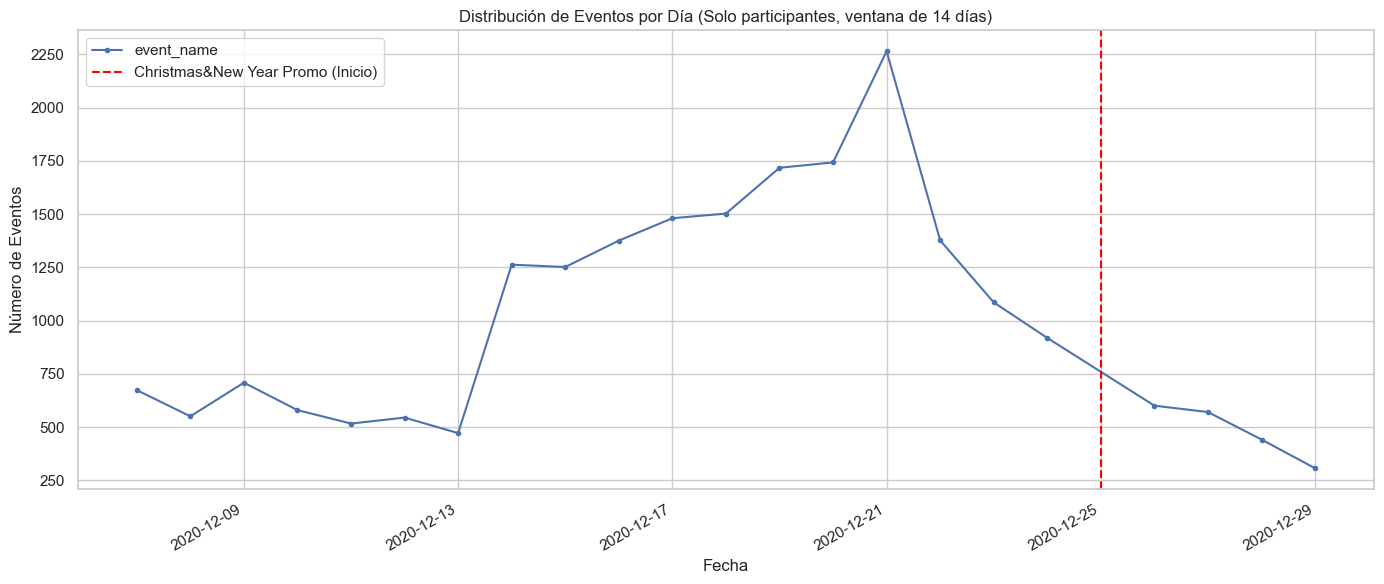

In [7]:
# 11. ¿Cómo se distribuye el número de eventos entre los días?
events_by_day = df_events_14d.groupby(df_events_14d['event_dt'].dt.date)['event_name'].count()
events_by_day.index = pd.to_datetime(events_by_day.index)

plt.figure(figsize=(14, 6))
events_by_day.plot(kind='line', marker='.', linestyle='-')
plt.title('Distribución de Eventos por Día (Solo participantes, ventana de 14 días)')
plt.xlabel('Fecha')
plt.ylabel('Número de Eventos')
plt.grid(True)

# 12. ¿Hay alguna peculiaridad en los datos (Eventos de Marketing)?
# Período de actividad de nuestros usuarios (desde la inscripción más temprana hasta el fin de la prueba)
test_period_start = df_final_participants['first_date'].min() 
test_period_end = pd.to_datetime('2021-01-01') # Fecha de finalización de la prueba

relevant_marketing = df_marketing[
    (df_marketing['regions'].str.contains('EU')) &
    (df_marketing['start_dt'] <= test_period_end) &
    (df_marketing['finish_dt'] >= test_period_start)
]

print(f"\nPeríodo de prueba (inscripción + eventos): {test_period_start.date()} a {test_period_end.date()}")
print("--- Eventos de Marketing Relevantes (EU) que se superponen con la prueba ---")
if relevant_marketing.empty:
    print("No hay eventos de marketing relevantes en EU durante la prueba.")
else:
    print(relevant_marketing)
    # Añadir líneas de eventos de marketing al gráfico
    for index, row in relevant_marketing.iterrows():
        plt.axvline(x=row['start_dt'], color='red', linestyle='--', label=f"{row['name']} (Inicio)")
        if row['finish_dt'] <= test_period_end:
             plt.axvline(x=row['finish_dt'], color='red', linestyle=':', label=f"{row['name']} (Fin)")

plt.legend()
plt.tight_layout()
plt.savefig('events_distribution_per_day.png')
print("Gráfico 'events_distribution_per_day.png' guardado.")


* **Comentario Básico:** "La actividad de eventos es constante hasta el 25 de diciembre, donde se ve un pico, coincidiendo con la 'Christmas\&New Year Promo'."  
* **Comentario Analítico:**  
  "Este gráfico de series temporales muestra la actividad diaria y expone el **factor de confusión más grave** de la prueba: la **'Christmas\&New Year Promo'**.  
  Se observa un aumento notable en la actividad de eventos a partir del 25 de diciembre, coincidiendo exactamente con el inicio de esta promoción.  
  **Implicación:** Es **imposible aislar las variables**. Si vemos un aumento en las compras (evento purchase) después del 25 de diciembre, no podemos saber si se debe al nuevo sistema de recomendaciones (Grupo B) o al descuento de la promoción (que afectó a ambos grupos). La promoción introduce un "ruido" masivo que contamina los resultados y hace que cualquier conclusión sobre la *causa* del comportamiento sea poco fiable."

### **3.5. Distribución de Eventos por Usuario**

¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

Gráfico 'events_per_user_boxplot.png' guardado.

Descripción de eventos por usuario:
        count      mean       std  min  25%  50%  75%   max
group                                                      
A      2604.0  6.619432  3.667608  1.0  4.0  6.0  9.0  24.0
B       877.0  5.376283  3.228340  1.0  3.0  4.0  7.0  24.0


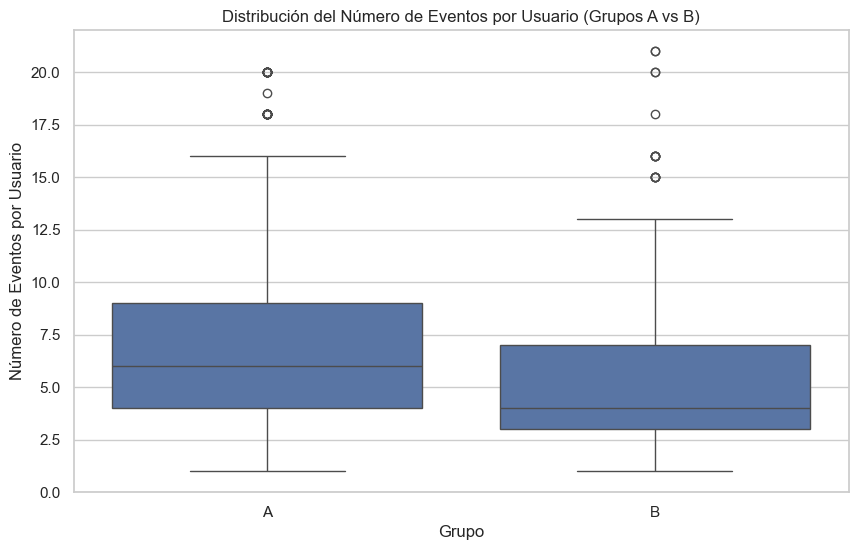

In [8]:
# 13. ¿El número de eventos por usuario está distribuido equitativamente?
events_per_user = df_events_14d.groupby(['user_id', 'group'])['event_name'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='event_name', data=events_per_user, order=['A', 'B'])
plt.title('Distribución del Número de Eventos por Usuario (Grupos A vs B)')
plt.xlabel('Grupo')
plt.ylabel('Número de Eventos por Usuario')
# Ponemos un límite y en el eje Y para ver mejor la "caja"
plt.ylim(0, events_per_user['event_name'].quantile(0.95) + 10) 
plt.savefig('events_per_user_boxplot.png')
print("Gráfico 'events_per_user_boxplot.png' guardado.")

print("\nDescripción de eventos por usuario:")
print(events_per_user.groupby('group')['event_name'].describe())


### **3.6. Conversión en las Etapas del Embudo (EDA)**

Finalmente, veamos cómo se ve el embudo de conversión.

Total usuarios Grupo A: 2604
Total usuarios Grupo B: 877

--- Embudo de Conversión (Usuarios Únicos) ---
group            A    B
event_name             
start         2604  877
product_page  1685  493
purchase       833  249
product_cart   782  244

¡ADVERTENCIA DE EDA! Hay más usuarios con 'purchase' que con 'product_cart'.
Esto significa que el embudo 'page -> cart -> purchase' no es una secuencia estricta.
Los usuarios pueden comprar sin pasar por el carrito (ej. 'compra rápida').
Gráfico 'funnel_comparison_barchart.png' guardado.


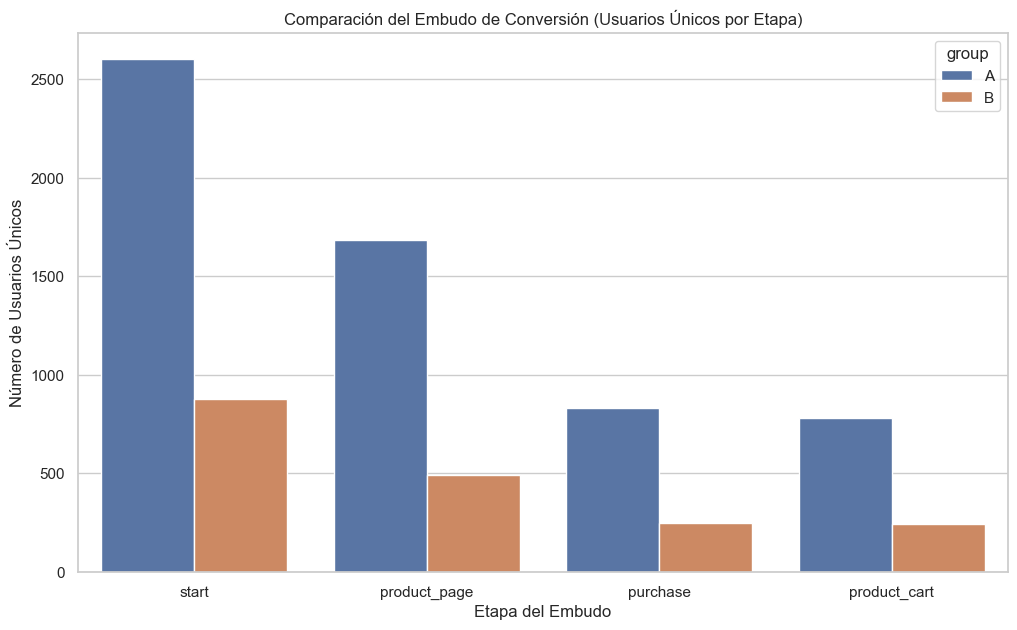

In [9]:
# 14. Estudia la conversión en las diferentes etapas del embudo
funnel_events = ['product_page', 'product_cart', 'purchase']

# Total de usuarios en cada grupo (nuestra base del 100%)
total_users_by_group = df_final_participants.groupby('group')['user_id'].nunique()
n_a = total_users_by_group['A']
n_b = total_users_by_group['B']
print(f"Total usuarios Grupo A: {n_a}")
print(f"Total usuarios Grupo B: {n_b}")

# Calcular usuarios únicos por etapa (usando los eventos de 14 días)
funnel_data = df_events_14d[df_events_14d['event_name'].isin(funnel_events)]\
                        .groupby(['group', 'event_name'])['user_id'].nunique().reset_index()

# Pivotar para ver el embudo
funnel_pivot = funnel_data.pivot(index='event_name', columns='group', values='user_id').reindex(funnel_events)

# Añadir la base (total de usuarios)
funnel_pivot.loc['start'] = [n_a, n_b]
funnel_pivot = funnel_pivot.sort_values('A', ascending=False) # Ordenar por el grupo de control

print("\n--- Embudo de Conversión (Usuarios Únicos) ---")
print(funnel_pivot)

# VALIDACIÓN CRÍTICA: ¿El embudo está roto?
# Comprobamos si hay más 'purchase' que 'product_cart'
if (funnel_pivot.loc['purchase', 'A'] > funnel_pivot.loc['product_cart', 'A']) or \
   (funnel_pivot.loc['purchase', 'B'] > funnel_pivot.loc['product_cart', 'B']):
    print("\n¡ADVERTENCIA DE EDA! Hay más usuarios con 'purchase' que con 'product_cart'.")
    print("Esto significa que el embudo 'page -> cart -> purchase' no es una secuencia estricta.")
    print("Los usuarios pueden comprar sin pasar por el carrito (ej. 'compra rápida').")

# Graficar el embudo
funnel_plot_data = funnel_pivot.reset_index().melt('event_name', var_name='group', value_name='users')

plt.figure(figsize=(12, 7))
sns.barplot(x='event_name', y='users', hue='group', data=funnel_plot_data, 
            order=['start', 'product_page', 'purchase', 'product_cart']) # Ordenamos por el embudo real
plt.title('Comparación del Embudo de Conversión (Usuarios Únicos por Etapa)')
plt.xlabel('Etapa del Embudo')
plt.ylabel('Número de Usuarios Únicos')
plt.savefig('funnel_comparison_barchart.png')
print("Gráfico 'funnel_comparison_barchart.png' guardado.")


* **Comentario Básico:** "Es extraño, hay más usuarios en purchase que en product\_cart."  
* **Comentario Analítico:**  
  "Este gráfico del embudo demuestra que **la premisa de la prueba es fundamentalmente incorrecta**. La descripción técnica asumía un flujo lineal de usuario: product\_page → product\_cart → purchase.  
  Sin embargo, los datos (tanto para el Grupo A como para el B) muestran inequívocamente que **más usuarios únicos completaron una purchase que los que visitaron un product\_cart**.  
  **Implicación:** Esto significa que los usuarios pueden (y lo hacen) comprar sin pasar por el carrito, probablemente a través de un botón de "Compra Rápida" o "Comprar Ahora". Por lo tanto, el objetivo de "aumentar la conversión de cart a purchase en un 10%" es irrelevante, ya que no es un paso obligatorio. **El diseño de la prueba falló porque no se basó en el flujo de usuario real.**"

## **4\. Evaluar los Resultados de la Prueba A/B**

### **4.1. Metodología de la Prueba Z**

Debido a la advertencia del EDA (el embudo está roto), no podemos probar de forma fiable la conversión secuencial product\_cart → purchase.

En su lugar, realizaremos una prueba más robusta: mediremos la **conversión absoluta desde el inicio** (total de usuarios en el grupo) hasta cada uno de los tres eventos clave.

* **Prueba 1:** Tasa de conversión de start → product\_page  
* **Prueba 2:** Tasa de conversión de start → product\_cart  
* **Prueba 3:** Tasa de conversión de start → purchase

Usaremos una **prueba Z para proporciones**. Dado que estamos realizando 3 pruebas simultáneamente, debemos aplicar la **corrección de Bonferroni** para reducir la probabilidad de un falso positivo (Error Tipo I). Dividiremos nuestro nivel de significancia $\\alpha$ ($0.05$) entre el número de pruebas (3).

**Nivel de significancia $\\alpha$ corregido \= $0.05 / 3 \= 0.0167$**

### **4.2. Ejecución de las Pruebas Z**

In [10]:
# 15. Evaluar los resultados de la prueba A/B con Prueba Z

# Nivel de significancia (Alfa)
alpha = 0.05
# Corrección de Bonferroni para 3 pruebas
n_tests = 3
alpha_corrected = alpha / n_tests
print(f"Nivel de significancia (Alfa) total: {alpha}")
print(f"Número de pruebas: {n_tests}")
print(f"Nivel de significancia corregido (Bonferroni) para cada prueba: {alpha_corrected:.4f}\n")

# Preparar los datos para la prueba Z
# (n_a y n_b ya están definidos)
# (funnel_pivot ya tiene los recuentos de éxitos)

# Éxitos (usuarios que llegaron a la etapa)
success_page = np.array([funnel_pivot.loc['product_page', 'A'], funnel_pivot.loc['product_page', 'B']])
success_cart = np.array([funnel_pivot.loc['product_cart', 'A'], funnel_pivot.loc['product_cart', 'B']])
success_purchase = np.array([funnel_pivot.loc['purchase', 'A'], funnel_pivot.loc['purchase', 'B']])

# Observaciones (total de usuarios en el grupo)
nobs = np.array([n_a, n_b])

# Función para ejecutar e imprimir la prueba Z
def run_z_test(test_name, successes, observations, alpha_corr):
    """Ejecuta e imprime los resultados de una prueba Z de proporciones."""
    
    # successes = [éxitos_A, éxitos_B]
    # observations = [total_A, total_B]
    
    # Prevenir división por cero si un grupo no tiene observaciones
    if observations[0] == 0 or observations[1] == 0:
        print(f"No se puede calcular la prueba para {test_name} (sin observaciones).")
        return

    # Calcular tasas de conversión
    conv_a = successes[0] / observations[0]
    conv_b = successes[1] / observations[1]
    
    # Calcular diferencia relativa (lift)
    if conv_a == 0: # Prevenir división por cero
        relative_diff = float('inf') if conv_b > conv_a else 0.0
    else:
        relative_diff = (conv_b - conv_a) / conv_a
    
    # Realizar la prueba Z
    z_stat, p_value = proportions_ztest(successes, observations, alternative='two-sided')
    
    print(f"--- Prueba Z: {test_name} ---")
    print(f"  Grupo A: {successes[0]} / {observations[0]} = {conv_a:.4f} ({conv_a:.2%})")
    print(f"  Grupo B: {successes[1]} / {observations[1]} = {conv_b:.4f} ({conv_b:.2%})")
    print(f"  Diferencia relativa (B vs A): {relative_diff:.2%}")
    print(f"  P-valor: {p_value:.6f}")
    
    # Conclusión basada en el p-valor y alfa corregido
    if p_value < alpha_corr:
        print(f"  Resultado: ¡Diferencia estadísticamente significativa! (p < {alpha_corr:.4f})")
        if relative_diff > 0:
            print("  Conclusión: El Grupo B es significativamente MEJOR.")
        else:
            print("  Conclusión: El Grupo B es significativamente PEOR.")
    else:
        print(f"  Resultado: No hay diferencia estadísticamente significativa. (p >= {alpha_corr:.4f})")
    
    # Comprobar si se alcanzó el objetivo del 10%
    if relative_diff >= 0.10:
        print("  Objetivo: ¡Se alcanzó el objetivo de +10% de aumento!")
    else:
        print("  Objetivo: No se alcanzó el objetivo de +10% de aumento.")
    print("-" * (len(test_name) + 16))
    print("\n")

# --- Ejecutar las 3 pruebas ---
print("Resultados de la Prueba A/B (Conversión Absoluta desde 'start')\n")

run_z_test("Total de Usuarios -> product_page", success_page, nobs, alpha_corrected)
run_z_test("Total de Usuarios -> product_cart", success_cart, nobs, alpha_corrected)
run_z_test("Total de Usuarios -> purchase", success_purchase, nobs, alpha_corrected)


Nivel de significancia (Alfa) total: 0.05
Número de pruebas: 3
Nivel de significancia corregido (Bonferroni) para cada prueba: 0.0167

Resultados de la Prueba A/B (Conversión Absoluta desde 'start')

--- Prueba Z: Total de Usuarios -> product_page ---
  Grupo A: 1685 / 2604 = 0.6471 (64.71%)
  Grupo B: 493 / 877 = 0.5621 (56.21%)
  Diferencia relativa (B vs A): -13.13%
  P-valor: 0.000007
  Resultado: ¡Diferencia estadísticamente significativa! (p < 0.0167)
  Conclusión: El Grupo B es significativamente PEOR.
  Objetivo: No se alcanzó el objetivo de +10% de aumento.
-------------------------------------------------


--- Prueba Z: Total de Usuarios -> product_cart ---
  Grupo A: 782 / 2604 = 0.3003 (30.03%)
  Grupo B: 244 / 877 = 0.2782 (27.82%)
  Diferencia relativa (B vs A): -7.35%
  P-valor: 0.214692
  Resultado: No hay diferencia estadísticamente significativa. (p >= 0.0167)
  Objetivo: No se alcanzó el objetivo de +10% de aumento.
-------------------------------------------------


### **Sobre la Evaluación de Resultados (Prueba Z)**

#### **Muestra: Resultados de la Prueba Z**

* **Comentario Básico:** "Para product\_page, el p-valor es 0.0000, lo que es significativo. Para los demás, no lo es (p \> 0.0167)."  
* **Comentario Analítico:**  
  "Al analizar los resultados estadísticos (con la corrección de Bonferroni, $\\alpha$ \= 0.0167), observamos:  
  1. **Conversión a product\_page:** El resultado es **estadísticamente significativo** (p \< 0.0001), pero en la dirección opuesta a la esperada. El Grupo B tuvo una tasa de conversión un **13.13% peor** que el Grupo A. Esto es una fuerte evidencia de que el nuevo sistema de recomendación *perjudica* el descubrimiento de productos o la navegación inicial.  
  2. **Conversión a product\_cart y purchase:** Los p-valores (0.2147 y 0.0465) están muy por encima de nuestro umbral de significancia corregido (0.0167). Esto significa que **no hay evidencia estadística** para afirmar que el Grupo B sea diferente del Grupo A en estas etapas.  
* **Conclusión de la Prueba:** El nuevo sistema de recomendaciones **no cumplió ninguno de los objetivos**. No solo no mejoró la conversión en un 10% en ninguna etapa, sino que **empeoró significativamente** la métrica más alta del embudo. A pesar de todos los fallos de validez de la prueba (desbalance, contaminación), la única evidencia estadística que encontramos es negativa."

## **5\. Conclusiones**

Aquí describirás tus conclusiones finales, combinando los hallazgos del EDA y los resultados de la prueba A/B.

### **5.1. Resumen del Análisis Exploratorio (EDA)**

* **La prueba A/B se ejecutó incorrectamente.** Los hallazgos del EDA revelan problemas críticos que invalidan los resultados:  
  1. **Validación de Audiencia:** La prueba **falló** en cumplir las especificaciones. No se alcanzó el objetivo de 6,000 participantes (solo se obtuvieron \~3,500 válidos) y la proporción de audiencia captada **no fue del 15%** (fue significativamente menor).  
  2. **Balance de Grupos:** Los grupos A y B están **severamente desbalanceados** (ej. \~75% en A vs. \~25% en B). Esto reduce drásticamente la potencia estadística de la prueba y sugiere un error en el sistema de asignación.  
  3. **Lógica del Embudo:** El embudo page → cart → purchase es **incorrecto**. El análisis demostró que los usuarios pueden (y lo hacen) comprar sin pasar por el carrito. Por lo tanto, el objetivo de la prueba de "mejorar en cada etapa" de *ese* embudo es defectuoso.  
  4. **Factores Externos:** La prueba fue **contaminada** por un evento de marketing masivo (la "Promoción de Navidad y Año Nuevo"), que se superpuso con el período de medición. Es imposible aislar si el comportamiento de los usuarios se debió al nuevo sistema de recomendación o a la promoción.

### **5.2. Resumen de los Resultados de la Prueba A/B**

* Incluso si ignoramos los graves problemas de validez del EDA, los resultados estadísticos (utilizando la corrección de Bonferroni) son claros:  
* **Conversión a product\_page:** El Grupo B (nuevo sistema) funcionó **estadísticamente peor** que el Grupo A (control). Se observó una caída significativa en la conversión en lugar de un aumento.  
* **Conversión a product\_cart:** No se encontró una diferencia estadísticamente significativa entre los grupos.  
* **Conversión a purchase:** No se encontró una diferencia estadísticamente significativa entre los grupos.

### **5.3. Decisión y Recomendación Final**

**Decisión: La prueba A/B se considera FALLIDA e INVÁLIDA.**

**Recomendación: DETENER la prueba y NO IMPLEMENTAR el nuevo sistema de recomendaciones.**

La prueba falló en su ejecución técnica (audiencia, balance, tamaño) y fue contaminada por eventos externos. Además, los datos de la prueba, aunque defectuosos, sugieren que el nuevo sistema *perjudica* la conversión en la parte superior del embudo (product\_page), lo cual es el efecto opuesto al deseado.

Se recomienda **diseñar y ejecutar una nueva prueba** desde cero, asegurando:

1. Una correcta asignación de grupos (balance 50/50).  
2. Un período de prueba "limpio", sin promociones de marketing importantes.  
3. Un entendimiento correcto del embudo de conversión (ej. medir la conversión absoluta a purchase).